# Matching the WEST ICRH Antenna

In this notebook we investigate the various method to match a WEST ICRH antenna. By matching the antenna we mean to find 4 capacitances values $C_1$, $C_2$, $C_3$ and $C_4$ in order for the antenna to be operated at a given frequency $f_0$. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import skrf as rf
import numpy as np
import sys
from tqdm.notebook import tqdm

sys.path.append('..')
from west_ic_antenna import WestIcrhAntenna

In [3]:
rf.stylely()

In [4]:
from west_ic_antenna import WestIcrhAntenna

## Matching Each Sides Separately
Here, each side of the antenna is matched separatly, which leads to two set of capacitances $(C_1, C_2)$ and $(C_3,C_4)$.

In the following example, both sides of the antenna are matched at the frequency $f_0$, keeping opposite side unmatched (C=150pF):

In [5]:
f0 = 55e6
freq = rf.Frequency(54, 56, npoints=1001, unit='MHz')
ant = WestIcrhAntenna(frequency=freq)  # default is vacuum coupling

In [6]:
C_match_left = ant.match_one_side(f_match=f0, side='left', solution_number=1)
C_match_right = ant.match_one_side(f_match=f0, side='right', solution_number=1)
print('Left side matching point: ', C_match_left)
print('Right side matching point: ', C_match_right)

True solution #1: [50.75832045 48.74412164]
True solution #1: [50.56074438 48.93365593]
Left side matching point:  [50.75832044651714, 48.744121635872304, 150, 150]
Right side matching point:  [150, 150, 50.56074438331907, 48.93365592549089]


Let's have a look to the RF reflection coefficient of each sides:

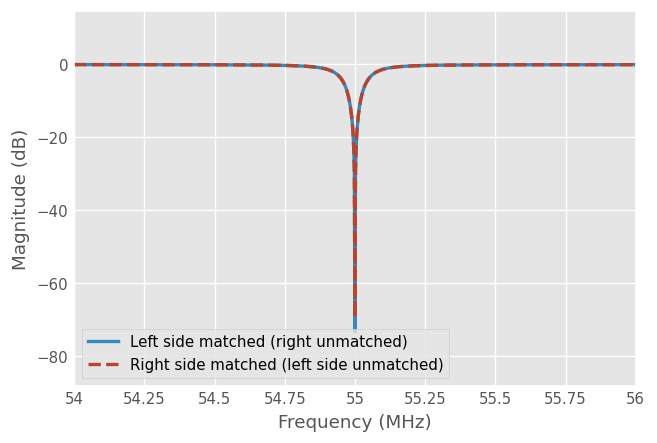

In [7]:
fig, ax = plt.subplots()
ant.circuit(Cs=C_match_left).network.plot_s_db(m=0, n=0, lw=2, ax=ax)
ant.circuit(Cs=C_match_right).network.plot_s_db(m=1, n=1, lw=2, ls='--', ax=ax)
ax.legend(('Left side matched (right unmatched)', 
           'Right side matched (left side unmatched)'))

In reality, the precision at which one can tune the capacitance is not better than 1/100 pF, so one have to consider rounding optimal solutions to such precision :


In [8]:
C_match_left = ant.match_one_side(f_match=f0, side='left', solution_number=1, decimals=2)
C_match_right = ant.match_one_side(f_match=f0, side='right', solution_number=1, decimals=2)
print('Left side matching point: ', C_match_left)
print('Right side matching point: ', C_match_right)

True solution #1: [50.75831875 48.74412295]
Rounded result: [50.76, 48.74, 150.0, 150.0]
True solution #1: [50.56074617 48.93365651]
Rounded result: [150.0, 150.0, 50.56, 48.93]
Left side matching point:  [50.76, 48.74, 150.0, 150.0]
Right side matching point:  [150.0, 150.0, 50.56, 48.93]


Note that the performances are slightly degraded, but, it's real life! 

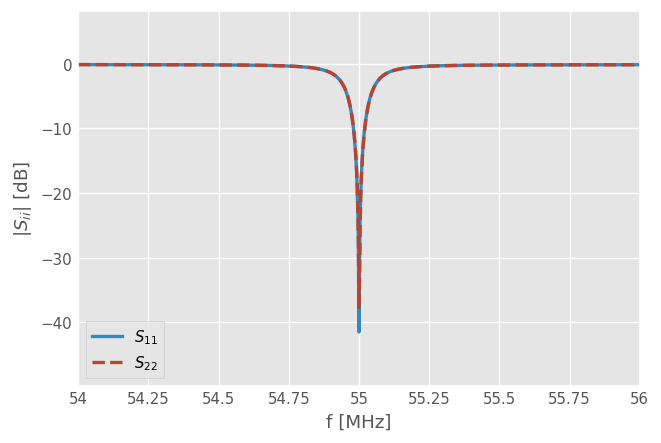

In [9]:
fig, ax = plt.subplots()
ant.circuit(Cs=C_match_left).network.plot_s_db(m=0, n=0, lw=2, ax=ax)
ant.circuit(Cs=C_match_right).network.plot_s_db(m=1, n=1, lw=2, ls='--', ax=ax)
ax.legend(('Left side matched (right unmatched)', 
           'Right side matched (left side unmatched)'))
ax.set_ylabel('$|S_{ii}|$ [dB]')
ax.set_xlabel('f [MHz]')
ax.legend(('$S_{11}$', '$S_{22}$'))

## Frequency Shift for Dipole Excitation
The coupling between antenna's sides requires shifting the frequency with respect to the matching frequency used for each side separately.

Thus, if the optimal capacitor set for both side are of the same kind (i.e. either both C_top>C_bot or both C_top<C_bot), then dipole excitation (phase $(0,\pi)$) requires to shift the frequency to higher frequency to operate the antenna in a optimal conditions:

In [10]:
# dipole excitation
power = [1, 1]
phase = [0, rf.pi]
# combine both separate solutions
C_match = [C_match_left[0], C_match_left[1], C_match_right[2], C_match_right[3]]
# looking to the active s parameters:
s_act = ant.s_act(power, phase, Cs=C_match)
# finding the optimum frequency
idx_f_opt = np.argmin(np.abs(s_act[:,0]))
f_opt = freq.f[idx_f_opt]
delta_f = f_opt - f0
print(f'Optimum frequency is f_opt={f_opt/1e6} MHz --> {delta_f/1e6} MHz shift' )

Optimum frequency is f_opt=55.212 MHz --> 0.212 MHz shift


Text(0.5, 1.0, 'Dipole excitation')

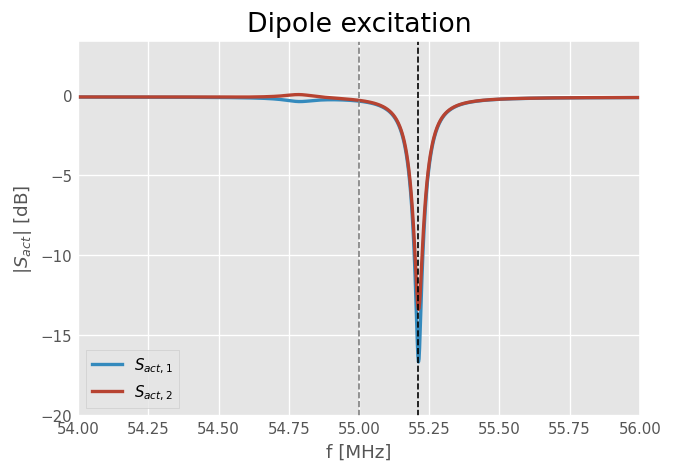

In [11]:
fig, ax = plt.subplots()
ax.plot(freq.f_scaled, 20*np.log10(np.abs(s_act)), lw=2)
ax.axvline(f0/1e6, ls='--', color='gray')
ax.axvline(f_opt/1e6, ls='--', color='k')
ax.set_ylabel('$|S_{act}|$ [dB]')
ax.set_xlabel('f [MHz]')
ax.legend(('$S_{act,1}$', '$S_{act,2}$'))
ax.set_title('Dipole excitation')

Monopole excitation (phase $(0,0)$) at the contrary requires shifting the operating frequency toward lower frequencies:

In [12]:
# monopole excitation
power = [1, 1]
phase = [0, 0]
# combine both separate solutions
C_match = [C_match_left[0], C_match_left[1], C_match_right[2], C_match_right[3]]
# looking to the active s parameters:
s_act = ant.s_act(power, phase, Cs=C_match)
# finding the optimum frequency
idx_f_opt = np.argmin(np.abs(s_act[:,0]))
f_opt = freq.f[idx_f_opt]
delta_f = f_opt - f0
print(f'Optimum frequency is f_opt={f_opt/1e6} MHz --> {delta_f/1e6} MHz shift' )

Optimum frequency is f_opt=54.786 MHz --> -0.214 MHz shift


Text(0.5, 1.0, 'Monopole excitation')

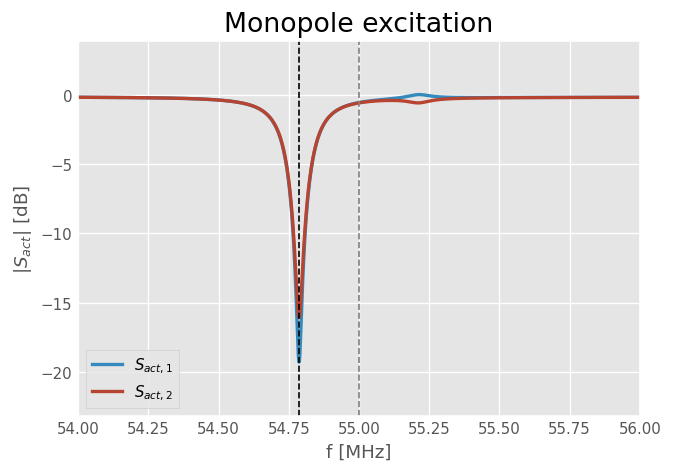

In [13]:
fig, ax = plt.subplots()
ax.plot(freq.f_scaled, 20*np.log10(np.abs(s_act)), lw=2)
ax.axvline(f0/1e6, ls='--', color='gray')
ax.axvline(f_opt/1e6, ls='--', color='k')
ax.set_ylabel('$|S_{act}|$ [dB]')
ax.set_xlabel('f [MHz]')
ax.legend(('$S_{act,1}$', '$S_{act,2}$'))
ax.set_title('Monopole excitation')

## Matching Both Sides at the same time
It is also possible to optimize the antenna directly for the target frequency and for a given excitation. Matching both sides at the same time in fact matches each side separately, then find the optimum points using these solutions as starting point to help the convergence of the optimization.

Two methods are available to match both sides of the antenna: `match_both_sides` which use the NumPy optimisation routines, and `match_both_sides_iterative` which uses the feedback matching algorithm (see [matching_automatic.ipynb](matching_automatic.ipynb) for more details). The primer is more robust in finding a solution, eventually at the price of a longer calculation. The later method can indeed be "lost" if the ideal solution is not close enough (or if the optimal region is too narrow, like under vacuum).

In [22]:
f0 = 55e6
freq = rf.Frequency(54, 56, npoints=1001, unit='MHz')
ant = WestIcrhAntenna(frequency=freq)  # default is vacuum coupling

# antenna excitation to match for
power = [1, 1]  # W
phase = [0, np.pi]  # dipole

ant.DEBUG=True  # display additional messages
# Providing an initial guess C0 skip the search on both sides separately
C0 = [C_match_left[0], C_match_left[1], C_match_right[2], C_match_right[3]]
C_opt_vacuum_dipole = ant.match_both_sides(f_match=f0, power=power, phase=phase, C0=C0, decimals=2)

Searching for the active match point solution...
Reducing search range to +/- 5pF around individual solutions
[50.76 48.74 50.56 48.93] 1.3577256499684232
[50.76000001 48.74       50.56       48.93      ] 1.3577256492480096
[50.76       48.74000001 50.56       48.93      ] 1.357725649820623
[50.76       48.74       50.56000001 48.93      ] 1.3577256492902046
[50.76       48.74       50.56       48.93000001] 1.3577256498142278
[50.80834613 48.7499187  50.60551448 48.94034787] 1.3527522335848088
[50.80834615 48.7499187  50.60551448 48.94034787] 1.3527522327601296
[50.80834613 48.74991872 50.60551448 48.94034787] 1.3527522333864037
[50.80834613 48.7499187  50.60551449 48.94034787] 1.3527522327977806
[50.80834613 48.7499187  50.60551448 48.94034789] 1.3527522333792479
[51.08633146 48.81675273 50.87079191 49.00959426] 1.300451170998385
[51.08633148 48.81675273 50.87079191 49.00959426] 1.3004511689581242
[51.08633146 48.81675274 50.87079191 49.00959426] 1.3004511700469588
[51.08633146 48.816

In [23]:
f0 = 55e6
freq = rf.Frequency(54, 56, npoints=1001, unit='MHz')
ant = WestIcrhAntenna(frequency=freq)  # default is vacuum coupling

# looking to the active s parameters:
s_act = ant.s_act(power, phase, Cs=C_opt_vacuum_dipole)

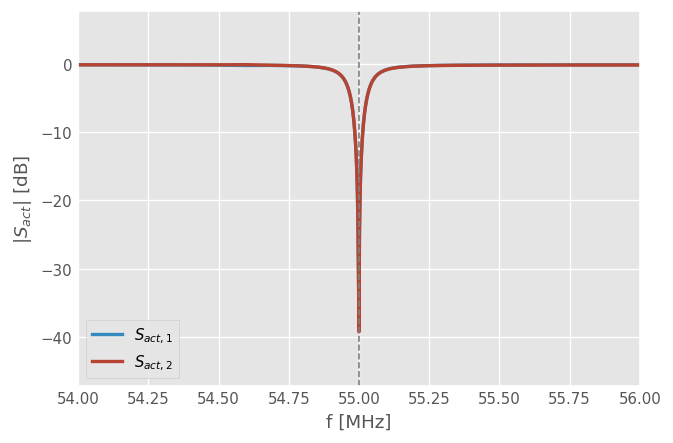

In [24]:
fig, ax = plt.subplots()
ax.plot(freq.f_scaled, 20*np.log10(np.abs(s_act)), lw=2)
ax.axvline(f0/1e6, ls='--', color='gray')
ax.set_ylabel('$|S_{act}|$ [dB]')
ax.set_xlabel('f [MHz]')
ax.legend(('$S_{act,1}$', '$S_{act,2}$'))

# Manual Matching on Plasma
When the antenna is facing the plasma, the coupling resistance increases and the antenna matching is affected.

If the operator keeps the matchpoint obtained on vacuum (in dipole for example), the antenna will have the following behaviour:

Text(0.5, 1.0, 'Reflection on plasma using vacuum matching setpoint')

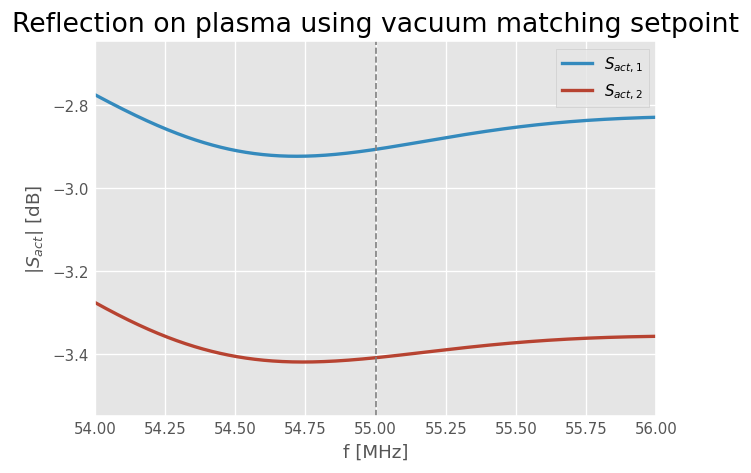

In [26]:
# changing the front-face of the antenna to a plasma case
freq = rf.Frequency(54, 56, npoints=1001, unit='MHz')
front_face_plasma = WestIcrhAntenna.interpolate_front_face(Rc=1, source='TOPICA-L-mode')
ant = WestIcrhAntenna(frequency=freq, front_face=front_face_plasma)  

# looking to the active s parameters in dipole:
powers = [1 ,1]
phases = [0, np.pi] 
s_act = ant.s_act(powers, phases , Cs=C_opt_vacuum_dipole)

fig, ax = plt.subplots()
ax.plot(freq.f_scaled, 20*np.log10(np.abs(s_act)), lw=2)
ax.axvline(f0/1e6, ls='--', color='gray')
ax.set_ylabel('$|S_{act}|$ [dB]')
ax.set_xlabel('f [MHz]')
ax.legend(('$S_{act,1}$', '$S_{act,2}$'))
ax.set_title('Reflection on plasma using vacuum matching setpoint')

Thus, it is necessary to re-adapt the capacitors to improve the matching of the antenna on plasma:

In [27]:
C_match_plasma = ant.match_both_sides(f0, power=powers, phase=phases, C0=C_opt_vacuum_dipole)

Searching for the active match point solution...
Reducing search range to +/- 5pF around individual solutions
True solution #1: [53.90470909 45.82709684 53.5084054  45.85984616]


Text(0.5, 1.0, 'Reflection on plasma after rematching')

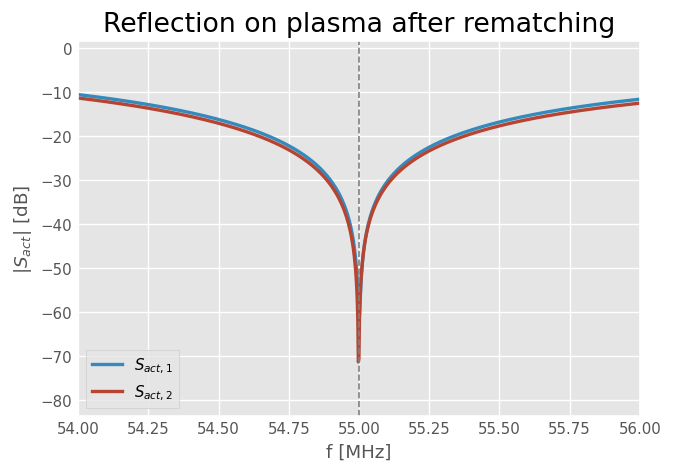

In [29]:
s_act = ant.s_act(powers, phases , Cs=C_match_plasma)

fig, ax = plt.subplots()
ax.plot(freq.f_scaled, 20*np.log10(np.abs(s_act)), lw=2)
ax.axvline(f0/1e6, ls='--', color='gray')
ax.set_ylabel('$|S_{act}|$ [dB]')
ax.set_xlabel('f [MHz]')
ax.legend(('$S_{act,1}$', '$S_{act,2}$'))
ax.set_title('Reflection on plasma after rematching')

If we compare the differences between capacitances setpoint between vacuum and plasma cases, we see that the difference between the values go like this:
* top capacitances are increased 
* bottom capacitances are decreased

Thus, the "distance" between top and bottom capacitance is increased. 

In [31]:
np.array(C_match_plasma) - np.array(C_vacuum)

array([ 2.70770909, -3.61390316,  2.4514054 , -3.84915384])

The capacitance shift to apply with respect to the vacuum setpoint depends of the coupling resistance of the plasma.

We can use this property to deduce the set of capacitors to use during plasma operation. Below we generate a series of various plasma loading cases, of increasing coupling resistance $R_c$. For each case we search for and we store the setpoints.

In [110]:
C_matchs = []

# note: on plasma loads, the iterative method is faster
# important : increase the gap between capacitances start point for the algorith to converge for high Rc cases
C0 = np.array(C_opt_vacuum_dipole) + np.array([+5, -5, +5, -5]) 

Rcs1 = np.linspace(0.39, 1.7, 10)  # TOPICA "H-mode" (low coupling)
for Rc in tqdm(Rcs1):
    _plasma = WestIcrhAntenna.interpolate_front_face(Rc=Rc, source='TOPICA-H-mode')
    _ant = WestIcrhAntenna(frequency=freq, front_face=_plasma)
    _C_match = _ant.match_both_sides_iterative(f0, power=powers, phase=phases, C0=C_opt_vacuum_dipole)
    C_matchs.append(_C_match)


Rcs2 = np.linspace(1, 2.9, 10)  # TOPICA "L-mode" (higher coupling)
for Rc in tqdm(Rcs2):
    _plasma = WestIcrhAntenna.interpolate_front_face(Rc=Rc, source='TOPICA-L-mode')
    _ant = WestIcrhAntenna(frequency=freq, front_face=_plasma)
    _C_match = _ant.match_both_sides_iterative(f0, power=powers, phase=phases, C0=C0)
    C_matchs.append(_C_match)

  0%|          | 0/10 [00:00<?, ?it/s]

Stopped after 18 iterations
Solution found: [52.43138381885247, 47.14148026242481, 52.147713667360435, 47.329635167967986]
Stopped after 20 iterations
Solution found: [53.036210988428834, 46.975477424840605, 52.776098857641294, 47.15118981913563]
Stopped after 23 iterations
Solution found: [53.590922674194964, 46.84875091316857, 53.31339941314105, 47.020204390871946]
Stopped after 25 iterations
Solution found: [54.08275212745384, 46.75564195353458, 53.79788794264683, 46.92433325171399]
Stopped after 27 iterations
Solution found: [54.53117177911998, 46.69181868084216, 54.239820011135855, 46.85924830673472]
Stopped after 30 iterations
Solution found: [54.950314445089255, 46.64251479814595, 54.649540722464224, 46.8071789810607]
Stopped after 34 iterations
Solution found: [55.336079895286304, 46.59668547765821, 55.02391531019124, 46.755319870011974]
Stopped after 38 iterations
Solution found: [55.68126259578362, 46.555587057947264, 55.35802515467148, 46.70608550808963]
Stopped after 42 ite

  0%|          | 0/10 [00:00<?, ?it/s]

Stopped after 27 iterations
Solution found: [53.71814720430081, 45.859764680510416, 53.29242765577917, 45.90505403159062]
Stopped after 30 iterations
Solution found: [54.013710305013205, 45.74383755792398, 53.584708096379245, 45.771515121422574]
Stopped after 35 iterations
Solution found: [54.3095299591251, 45.60012406922039, 53.874645057269994, 45.58819604767345]
Stopped after 42 iterations
Solution found: [54.576232723470305, 45.451794182437574, 54.135803606360206, 45.378019961738296]
Stopped after 50 iterations
Solution found: [54.76915666315925, 45.30443001947543, 54.3215820611324, 45.1535486387689]
Stopped after 61 iterations
Solution found: [54.758564662536465, 45.05040460817807, 54.285469338509756, 44.72415573345071]
Stopped after 61 iterations
Solution found: [54.605569466529246, 44.86121453756759, 54.01203426678169, 44.31870157597288]
Stopped after 61 iterations
Solution found: [54.6368097731353, 44.848172225668, 53.93598481680817, 44.23864124176281]
Stopped after 61 iteration

Let's plot the average capacitance shift to apply versus the coupling resistance of the plasma loading scenario:

In [104]:
Rcs3 = np.linspace(0.3, 1.6, 10)

In [111]:
diff_C = np.array(C_matchs) - np.array(C_vacuum)

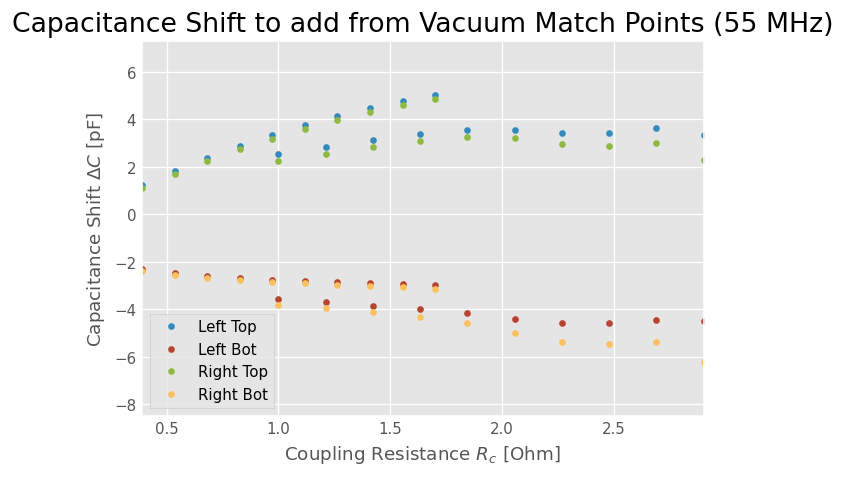

In [112]:
Rcs=np.concatenate([Rcs1, Rcs2])
fig, ax = plt.subplots()
ax.plot(Rcs, diff_C, 'o')
ax.set_xlabel('Coupling Resistance $R_c$ [Ohm]')
ax.set_ylabel('Capacitance Shift $\Delta C$ [pF]')
ax.set_title('Capacitance Shift to add from Vacuum Match Points (55 MHz)')
ax.legend(['Left Top', 'Left Bot', 'Right Top', 'Right Bot'])

In [115]:
Cs=list(np.array(C_opt_vacuum_dipole) + np.array([+3, -3, +3, -3]))

In [118]:
np.argmin(np.abs(ant.frequency.f - 55e6))

500

In [143]:
C_left, C_right, err = ant.capacitor_predictor(powers, phases, Cs=Cs)
Cs=[*C_left[500], *C_right[500]]
print(Cs)

[53.68967593717993, 45.89768667418638, 53.275450238831574, 45.97734813240914]


Text(0.5, 1.0, 'Reflection on plasma after rematching')

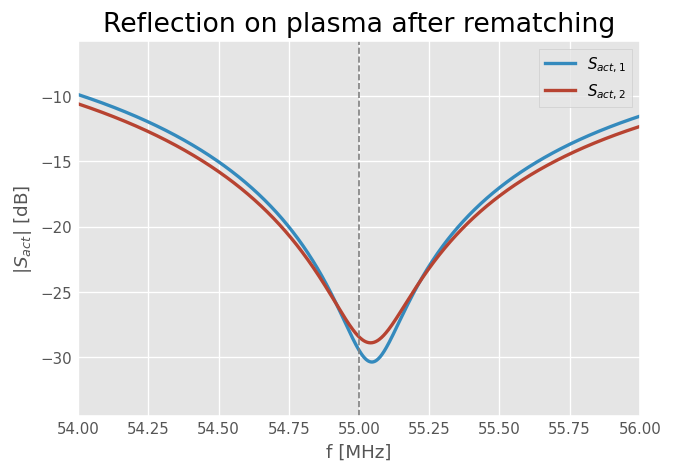

In [144]:
s_act = ant.s_act(powers, phases , Cs=Cs)

fig, ax = plt.subplots()
ax.plot(freq.f_scaled, 20*np.log10(np.abs(s_act)), lw=2)
ax.axvline(f0/1e6, ls='--', color='gray')
ax.set_ylabel('$|S_{act}|$ [dB]')
ax.set_xlabel('f [MHz]')
ax.legend(('$S_{act,1}$', '$S_{act,2}$'))
ax.set_title('Reflection on plasma after rematching')

This plot should be benchmark against plasma measurements.

In [1]:
from IPython.core.display import HTML
def _set_css_style(css_file_path):
    """
    Read the custom CSS file and load it into Jupyter
    Pass the file path to the CSS file
    """
    styles = open(css_file_path, "r").read()
    s = '<style>%s</style>' % styles
    return HTML(s)

_set_css_style('custom.css')